# Speaker clustering

In [5]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 16, 8

from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn import metrics

import sys
import os
import glob
import random

import librosa
import librosa.display

In [6]:
#DEFINICIO VARIABLES 
base_path = '/home/jc/pav/practica4'    #Carpeta practica 4
speecon_path = os.path.join(base_path,'audios','speecon')    #Carpeta Speecon
temp_path = os.path.join(base_path,'exports')    #Carpeta exports

In [15]:
def mfcc(files, n_coefs=16):
    ''' Función genérica MFCC
        Función genérica para calcular los coeficientes MFCC dada
        una lista con los paths a los audios.
        Utiliza la libreria librosa para leer el
        audio y calcular los coeficientes.
        Parametros:
        - files: lista con los ficheros a computar
        - n_coefs: int numero de coeficientes para el MFCC
        Devuelve:
        - base: np.array de tamaño Nxn_coefs con los coeficientes para cada trama'''
    
    #Inicializamos un array a ceros
    base = np.zeros((1,n_coefs))
    
    for file_audio in files:
        #Lectura del audio, remuestreamos a 8000Hz
        audio, fs = librosa.core.load(file_audio, sr=8000)
        #Calculo de los coefs
        mfcc_raw = librosa.feature.mfcc(audio, sr=fs, n_mfcc=n_coefs).T
        #Stack de la base de datos con los mfcc calculados
        base = np.vstack((base,mfcc_raw))
    
    return base[1:] #El primero no lo devolvemos porqué son los ceros de inializacion

In [16]:
def read_mfcc(path):
    ''' Reads mfcc file from person
        Parametros:
        - path: path donde leer el mfcc
    '''
    mfcc = np.loadtxt(path, delimiter=',')
    
    return mfcc

In [7]:
def compute_mfccs(audiolist,n_coefs):
    ''' Calculo de los MFFCs (contenemos todos los datos en memoria)'''
    # Contenedor de datos
    audio_mfcc = list()
    
    # Iteramos todos los audios de la lista
    for audio in audiolist:
        audio_mfcc.append(mfcc([audio],n_coefs))
    return audio_mfcc

In [8]:
def compute_gmms(mfcc_list,n_gmms):
    ''' Calculo de las GMMs'''
    # Contenedor de datos
    audio_gmm = list()
    
    # Iteramos todas las mfcc de la lista
    for mfcc_a in mfcc_list:
        gmm=GMM(n_gmms, n_init=2).fit(mfcc_a) 
        audio_gmm.append(gmm)
    
    return audio_gmm

In [9]:
def compute_matrix(mfcc_list,gmm_list):
    ''' Calculo de la matriz
        Calculamos la score de cada audio para cada gmm, 
        con esto obtenemos una matriz (NxN)
    '''
    
    # Obtenemos el tamaño de la lista de mfcc
    l = len(mfcc_list)
    # Inicializamos matriz a ceros
    data = np.zeros([l,l])

    # Iteramos la matriz y la llenamos con los datos
    for i in range(0,l):
        for j in range(0,l):
            # Calculo de la score del audio con la gmm en concreto
            data[i,j] = gmm_list[i].score(mfcc_list[j]) 
    
        #data[i,:] = data[i,:]/(-sum(data[i,:])/l)
    
    return data

In [10]:
def plot_data(data):
    ''' Plot matriz imshow()'''
    plt.figure(figsize=(10,10))
    plt.imshow(data);
    plt.colorbar()
    plt.show()

In [11]:
def update_mfcc(pos, mfcc_list):
    ''' Actualización del contenedor de MFFCs
        Concatena los dos segmentos que unimos y saca
        de la lista el segundo componente'''
    mfcc_list[pos[0]] = np.concatenate((mfcc_list[pos[0]],mfcc_list[pos[1]]))
    mfcc_list.pop(pos[1])
    
    return mfcc_list

In [12]:
def find_max(data,n):
    ''' Busqueda del maximo en la matriz data
        Esta función busca el valor máximo en la matriz para 
        juntar los datos en la siguiente iteración.
        Definimos unas normas para optimizar el resultado, las dos 
        más importantes són; 
        - Si es una diagonal, indice i y j igual no
        lo contamos ya que es el mismo audio. 
        - No se pueden juntar dos grupos grandes (6>) de audios, 
        así evitamos crear un grupo gigante que contenga todos los audios.
        Parametros: 
        - data: Matriz de datos
        - n: Lista con los grupos que se van formando
        Devuelve:
        - Pos: Lista de dos valores que contiene el indice i y j del valor
        máximo, ordenado en orden ascendente.
    '''
    # Valor que comparamos
    m = None
    # Variable de la posición
    pos = None
    
    # Lista con los tamaños de los clusters
    sizes = [len(n[c]) for c in range(0,len(n))]
    # Lista con los tamaños de los clusters en orden ascendente
    sorted_sizes = sorted(sizes,reverse=True)
    
    # Iteramos la matriz de datos
    for i in range(0,data.shape[0]):
        for j in range(0,data.shape[1]):
            
            # Batería de filtros
            if i==j : break
            #if ((sizes[i]>2) or (sizes[j]>2)) and (((sizes[i]*1.2)<sizes[j]) or (sizes[i]>(1.2*sizes[j]))): break
            #if (i==no) or (j==no): break
            #if (max(sizes)>6) and (i==sizes.index(sorted_sizes[0]) and j==sizes.index(sorted_sizes[1])): 
                #print(i,sizes.index(sorted_sizes[0]),j,sizes.index(sorted_sizes[1]))
                #break
            if (max(sizes)>6) and (((i==0) and (j==1)) or ((i==1) and (j==0))): break
            #if (i==sizes.index(sorted_sizes[0])) and (j==sizes.index(sorted_sizes[1])): 
            #    print(i,sizes.index(sorted_sizes[0]),j,sizes.index(sorted_sizes[1]))
            #    break
            
            # Miramos si encontramos un máximo
            if (m==None) or (m<data[i,j]):
                m = data[i,j]
                pos = [i,j]
    
    # Devolvemos los datos
    return [min(pos),max(pos)]

In [13]:
def clustering(person1,person2,show=True):
    ''' Clustering de los audios'''
    # Lectura de los ficheros a detectar
    audio1 = glob.glob(person1+'/*.wav')
    audio2 = glob.glob(person2+'/*.wav')
    audio1.extend(audio2)
    audiolist = audio1

    # Inicialización de los datos
    mfcc_list = compute_mfccs(audiolist,6)
    gmm_list = compute_gmms(mfcc_list,2)
    data = compute_matrix(mfcc_list,gmm_list)

    # Presentación de los datos iniciales
    if show:
        print('Matriz de datos iniciales:')
        plot_data(data)

    # Inicialización de los clusters
    # Usamos una lista conteniendo una lista con su 
    # propio indice. Luego extendemos la lista con cada
    # actualización del mapa. Finalmente resultan dos 
    # listas que representan los dos clusters finales
    n = [[i] for i in range(0,40)]

    for i in range(0,38):
        # Encontramos el máximo en la matriz
        pos = find_max(data,n)

        # Debug de datos
        #print(pos)
        #print(n)

        # Actualización de los datos de la lista de clusters
        n[pos[0]].extend(n[pos[1]])
        n.pop(pos[1])

        # Actualización de los datos en la lista de MFCCs
        mfcc_list = update_mfcc(pos, mfcc_list)

        # Calculo de las gmms actualizadas
        gmm_list = compute_gmms(mfcc_list,2)

        # Calculo de la matriz de esta iteración
        data = compute_matrix(mfcc_list,gmm_list)

        # Visualización de los datos
        #plot_data(data)

    print('Clusters finales:')
    print(n)

    # Evaluación de los datos
    n00 = (np.array(n[0])>=20)
    n01 = (np.array(n[0])<=19)
    n10 = (np.array(n[1])>=20)
    n11 = (np.array(n[1])<=19)

    if sum(n00)>sum(n01):
        speaker1 = np.array(n[1])
        speaker2 = np.array(n[0])
    else:
        speaker1 = np.array(n[0])
        speaker2 = np.array(n[1])

    precision1 = sum(speaker1<=19)/speaker1.shape[0]
    recall1 = sum(speaker1<=19)/20
    if show:
        print(f'\nPrecision: {precision1} Recall: {recall1}')

    precision2 = sum(speaker2>=20)/speaker2.shape[0]
    recall2 = sum(speaker2>=20)/20
    if show:
        print(f'\nPrecision: {precision2} Recall: {recall2}')

    p_total = (precision1+precision2)/2
    r_total = (recall1+recall2)/2
    
    print(f'\nValores finales: {p_total} {r_total}\n')

    return [p_total,r_total]

Matriz de datos iniciales:


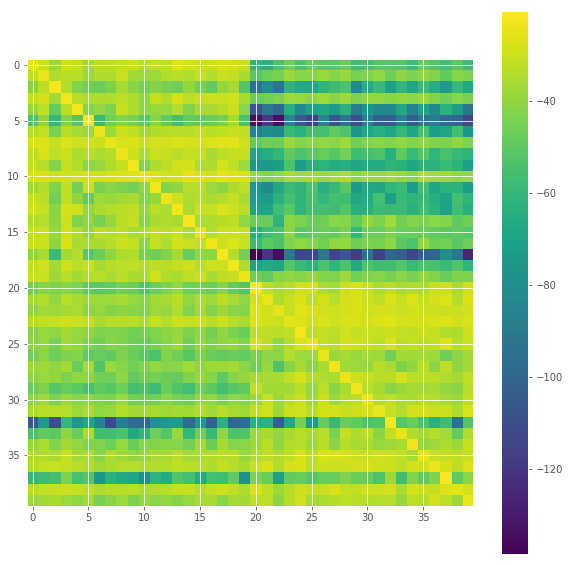

Clusters finales:
[[0, 1, 7, 3, 5, 8, 9, 10, 14, 16, 18, 6, 15, 19, 4, 17, 12], [2, 11, 13, 20, 22, 21, 24, 32, 37, 38, 23, 25, 26, 35, 27, 30, 31, 28, 29, 36, 34, 39, 33]]

Precision: 1.0 Recall: 0.85

Precision: 0.8695652173913043 Recall: 1.0

Valores finales: 0.9347826086956521 0.925



[0.9347826086956521, 0.925]

In [17]:
# Definición de las paths a las personas que vamos a usar en el análisis
person1 = '/home/jc/speech_processing_notebooks/audios/speecon/BLOCK00/SES001'
person2 = '/home/jc/speech_processing_notebooks/audios/speecon/BLOCK18/SES185'

clustering(person1,person2)

In [18]:
# Lectura de los ficheros de speecon
ficheros = glob.glob('/home/jc/pav/practica4/audios/speecon/*/*')

# Variables para calcular metricas
precision = 0
recall = 0

# Iteramos 10 veces (n experimentos)
for count in range(0,10):
    # Realizamos una muestra de los ficheros
    paths = random.sample(ficheros,k=2)
    # Guardamos las metricas
    metrics = clustering(paths[0], paths[1], show=False)
    precision += metrics[0]
    recall += metrics[1]

# Métricas finales    
precision = precision/count
recall = recall/count

print(f'\nPrecision: {precision} Recall: {recall}')

Clusters finales:
[[0, 1, 14, 7, 15, 18, 6, 8, 3, 4, 16, 5, 12, 9, 17, 19, 10, 13], [2, 11, 20, 21, 22, 24, 26, 32, 36, 23, 29, 39, 27, 30, 33, 28, 31, 34, 38, 25, 35, 37]]

Valores finales: 0.9545454545454546 0.95

Clusters finales:
[[0, 18, 20, 23, 21, 22, 24, 31, 26, 29, 28, 34, 39, 25, 36, 32, 33, 27, 37, 30, 35, 38], [1, 2, 5, 12, 15, 4, 6, 16, 17, 7, 13, 9, 11, 3, 10, 8, 14, 19]]

Valores finales: 0.9545454545454546 0.95

Clusters finales:
[[0, 20, 21, 28, 36, 22, 25, 27, 30, 31, 24, 35, 29, 37, 26, 34, 32, 33, 38, 39, 23], [1, 12, 15, 3, 5, 11, 6, 2, 8, 14, 16, 7, 10, 13, 4, 9, 17, 18, 19]]

Valores finales: 0.9761904761904762 0.975

Clusters finales:
[[0, 18, 20, 25, 26, 31, 34, 21, 22, 24, 30, 32, 36, 27, 33, 35, 28, 37, 38, 23, 29, 39], [1, 15, 19, 5, 16, 6, 8, 2, 3, 12, 14, 9, 7, 13, 10, 17, 11, 4]]

Valores finales: 0.9545454545454546 0.95

Clusters finales:
[[0, 1, 5, 13, 16, 18, 19, 11, 8, 6, 20, 29, 33, 34, 35, 38, 21, 27, 12, 23, 36, 24, 28, 32, 26, 39, 22, 30, 37, 25],